In [120]:
import pyreadr

import numpy as np
import pandas as pd

from sklearn import preprocessing
from scipy.special import comb, logsumexp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
import tensorflow as tf

import matplotlib.pyplot as plt

import random

In [121]:
PATH_BUILDING_ENERGY_FEATURIZED = "../data/building_energy_featurized.csv"

PATH_BUILDING_ENERGY_FEATURIZED_ZSCORE = "../data/building_energy_featurized_zscore.csv"
PATH_BUILDING_ENERGY_FEATURIZED_UNDO_ZSCORE = "../data/building_energy_featurized_undo_zscore.csv"

PATH_BUILDING_ENERGY_LSTM_ZSCORE = "../data/building_energy_lstm_zscore.csv"
PATH_BUILDING_ENERGY_LSTM_UNDO_ZSCORE = "../data/building_energy_lstm_undo_zscore.csv"

random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

In [122]:
#building_energy_featurized = pd.read_csv(PATH_BUILDING_ENERGY_FEATURIZED)
building_energy_featurized_zscore = pd.read_csv(PATH_BUILDING_ENERGY_FEATURIZED_ZSCORE)
building_energy_featurized_undo_zscore = pd.read_csv(PATH_BUILDING_ENERGY_FEATURIZED_UNDO_ZSCORE)

BUILDING_ENERGY_DATASET = building_energy_featurized_zscore

In [123]:
# Rows with kwh values of 0 are removed to allow for log-scaling (per-building standard scaling to z-scores eliminates need for log scaling)
# log_building_energy_featurized = BUILDING_ENERGY_DATASET.apply(lambda x: np.log(x.replace(0, np.nan)) if x.name.startswith("kwh_sim_") else x).dropna()

building_energy_scaled = BUILDING_ENERGY_DATASET

# Scale temporal variables via simple minmax (because they are roughly uniformly distributed)
min_max_scaler = preprocessing.MinMaxScaler()
building_energy_scaled[['year', 'month', 'day', 'hour']] = min_max_scaler.fit_transform(building_energy_scaled[['year', 'month', 'day', 'hour']])

In [397]:
building_energy_scaled = building_energy_scaled[building_energy_scaled['target_00600470060000'] == 1]

In [124]:
temp_data = building_energy_scaled
temp_data['kwh_actual_1'] = temp_data['kwh_actual']

In [125]:
X_train = temp_data.query('year < 0.6')
#y_train = np.array(X_train.filter(items=['kwh_actual']))
X_train = np.array(X_train.drop(columns=['kwh_actual']))

X_val = temp_data.query('year > 0.6 and year < 0.7')
#y_val = np.array(X_val.filter(items=['kwh_actual']))
X_val = np.array(X_val.drop(columns=['kwh_actual']))

In [126]:
train_undo_zscore = X_train[:, 4:6]
val_undo_zscore = X_val[:, 4:6]

In [127]:
X_train = np.delete(X_train, [4, 5], 1)
X_val = np.delete(X_val, [4, 5], 1)
#X_test = np.delete(X_test, [4, 5], 1)

print(X_train.shape, X_val.shape)

(508732, 75) (254032, 75)


In [101]:
#X = np.array(building_energy_scaled.drop(columns=['kwh_actual']))
y = np.array(building_energy_scaled.filter(items=['kwh_actual']))
#building_energy_scaled['kwh_actual_1'] = building_energy_scaled['kwh_actual']
X = np.array(building_energy_scaled.drop(columns=['kwh_actual']))

X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X, y, test_size=0.3, shuffle = False)
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.5, shuffle = False)

train_undo_zscore = X_train[:, 4:6]
val_undo_zscore = X_val[:, 4:6]
test_undo_zscore = X_test[:, 4:6]

X_train = np.delete(X_train, [4, 5], 1)
X_val = np.delete(X_val, [4, 5], 1)
X_test = np.delete(X_test, [4, 5], 1)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(533955, 75) (114419, 75) (114419, 75) (533955, 1) (114419, 1) (114419, 1)


In [11]:
# Model that predicts the mean for each building (i.e. 0 z-score)

y_predictions = np.zeros(y_val.ravel().shape)
true_y_predictions = np.multiply(y_predictions.ravel(), val_undo_zscore[:, 1]) + val_undo_zscore[:, 0]
true_y_val = np.multiply(y_val.ravel(), val_undo_zscore[:, 1]) + val_undo_zscore[:, 0]
y_out = np.column_stack((true_y_predictions, true_y_val.astype(int)))
y_out = y_out[y_out[:, 1] != 0]

print("MAPE: " + str(100 * np.mean(np.abs(y_out[:, 0] / y_out[:, 1] - 1))))
print("CV(RMSE): " + str(100 * np.sqrt(np.mean(np.power(true_y_predictions - true_y_val, 2))) / np.mean(true_y_val)))
print("MBE: " + str(np.mean(true_y_predictions - true_y_val)))

MAPE: 50.23810565924801
CV(RMSE): 60.82001482729228
MBE: 0.5915777616910632


In [362]:
true_y_predictions

array([ 22.04114184,  29.6054521 ,  30.82415173, ..., 271.84608336,
       219.77606038, 214.67018949])

In [365]:
true_y_val

array([ 23.,  23.,  22., ..., 233., 201., 179.])

In [12]:
lr_model = LinearRegression()
lr_model = lr_model.fit(X_train, y_train)

In [13]:
# Linear Model

y_predictions = lr_model.predict(X_val)
true_y_predictions = np.multiply(y_predictions.ravel(), val_undo_zscore[:, 1]) + val_undo_zscore[:, 0]
true_y_val = np.multiply(y_val.ravel(), val_undo_zscore[:, 1]) + val_undo_zscore[:, 0]
y_out = np.column_stack((true_y_predictions, true_y_val.astype(int)))
y_out = y_out[y_out[:, 1] != 0]

print("MAPE: " + str(100 * np.mean(np.abs(y_out[:, 0] / y_out[:, 1] - 1))))
print("CV(RMSE): " + str(100 * np.sqrt(np.mean(np.power(true_y_predictions - true_y_val, 2))) / np.mean(true_y_val)))
print("MBE: " + str(np.mean(true_y_predictions - true_y_val)))

MAPE: 36.80299065838396
CV(RMSE): 41.5081875479324
MBE: 0.1751772472366204


In [503]:
gb_model = GradientBoostingRegressor()
gb_model = gb_model.fit(X_train, y_train.ravel())

In [504]:
# Gradient Boost Model

y_predictions = gb_model.predict(X_val)
true_y_predictions = np.multiply(y_predictions.ravel(), val_undo_zscore[:, 1]) + val_undo_zscore[:, 0]
true_y_val = np.multiply(y_val.ravel(), val_undo_zscore[:, 1]) + val_undo_zscore[:, 0]
y_out = np.column_stack((true_y_predictions, true_y_val.astype(int)))
y_out = y_out[y_out[:, 1] != 0]

print("MAPE: " + str(100 * np.mean(np.abs(y_out[:, 0] / y_out[:, 1] - 1))))
print("CV(RMSE): " + str(100 * np.sqrt(np.mean(np.power(true_y_predictions - true_y_val, 2))) / np.mean(true_y_val)))
print("MBE: " + str(np.mean(true_y_predictions - true_y_val)))

MAPE: 29.6215692501416
CV(RMSE): 36.903966564640584
MBE: -0.008873762705407087


In [25]:
nn_model = Sequential()
nn_model.add(Dense(128, activation='relu', input_shape=[X_train.shape[1]]))
# nn_model.add(Dense(128, activation='relu'))
nn_model.add(Dense(1))

nn_model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping_monitor = EarlyStopping(patience=3)

nn_model.fit(X_train, y_train, validation_data=[X_val, y_val], epochs=10, callbacks=[early_stopping_monitor])

Train on 533955 samples, validate on 114419 samples
Epoch 1/10
533955/533955 [==============================] - 17s 31us/step - loss: 0.4483 - val_loss: 0.3684
Epoch 2/10
533955/533955 [==============================] - 16s 31us/step - loss: 0.3569 - val_loss: 0.3233
Epoch 3/10
533955/533955 [==============================] - 16s 31us/step - loss: 0.3235 - val_loss: 0.3218
Epoch 4/10
533955/533955 [==============================] - 16s 31us/step - loss: 0.3113 - val_loss: 0.3220
Epoch 5/10
533955/533955 [==============================] - 17s 32us/step - loss: 0.3030 - val_loss: 0.2970
Epoch 6/10
533955/533955 [==============================] - 17s 31us/step - loss: 0.2966 - val_loss: 0.2899
Epoch 7/10
533955/533955 [==============================] - 17s 31us/step - loss: 0.2915 - val_loss: 0.2819
Epoch 8/10
533955/533955 [==============================] - 17s 31us/step - loss: 0.2869 - val_loss: 0.2786
Epoch 9/10
533955/533955 [==============================] - 17s 31us/step - loss: 0.

In [137]:
# Fully Connected Two-Layer NN Model

y_predictions = nn_model.predict(X_val)
true_y_predictions = np.multiply(y_predictions.ravel(), val_undo_zscore[:, 1]) + val_undo_zscore[:, 0]
true_y_val = np.multiply(y_val.ravel(), val_undo_zscore[:, 1]) + val_undo_zscore[:, 0]
y_out = np.column_stack((true_y_predictions, true_y_val.astype(int)))
y_out = y_out[y_out[:, 1] != 0]

print("MAPE: " + str(100 * np.mean(np.abs(y_out[:, 0] / y_out[:, 1] - 1))))
print("CV(RMSE): " + str(100 * np.sqrt(np.mean(np.power(true_y_predictions - true_y_val, 2))) / np.mean(true_y_val)))
print("MBE: " + str(np.mean(true_y_predictions - true_y_val)))

ValueError: Error when checking input: expected dense_4_input to have shape (74,) but got array with shape (75,)

In [128]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [129]:
N_IN = 8
Y_INDEX = 75

X_sup_train = series_to_supervised(X_train, n_in=N_IN)
# X_sup_train.drop(X_sup_train.iloc[:, -75:-1], inplace = True, axis = 1)
# X_sup_train = np.array(X_sup_train)
prev_y_vals = []
for i in range(N_IN):
    prev_y_vals.append(X_sup_train.iloc[:, 75 * (i + 1) - 1].name) # var75(t-8), ..., var75(t-1)
X_sup_train.drop(columns = prev_y_vals, axis = 1, inplace = True)
X_sup_train = np.array(X_sup_train)

X_sup_val = series_to_supervised(X_val, n_in=N_IN)
# X_sup_val.drop(X_sup_val.iloc[:, -75:-1], inplace = True, axis = 1)
# X_sup_val = np.array(X_sup_val)
prev_y_vals = []
for i in range(N_IN):
    prev_y_vals.append(X_sup_val.iloc[:, 75 * (i + 1) - 1].name) # var75(t-8), ..., var75(t-1)
X_sup_val.drop(columns = prev_y_vals, axis = 1, inplace = True)
X_sup_val = np.array(X_sup_val)

X_train, y_train = X_sup_train[:, :-1], X_sup_train[:, -1]
X_val, y_val = X_sup_val[:, :-1], X_sup_val[:, -1]
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(508724, 666) (508724,) (254024, 666) (254024,)


In [130]:
nn_model = Sequential()
nn_model.add(Dense(128, activation='relu', input_shape=[X_train.shape[1]]))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(1))

nn_model.compile(optimizer='adam', loss='mean_absolute_error')
#early_stopping_monitor = EarlyStopping(patience=3)

nn_model.fit(X_train, y_train, validation_data=[X_val, y_val], epochs=50, batch_size = 5000, shuffle = False)

Train on 508724 samples, validate on 254024 samples
Epoch 1/50
508724/508724 [==============================] - 7s 15us/step - loss: 0.7525 - val_loss: 0.6174
Epoch 2/50
508724/508724 [==============================] - 7s 14us/step - loss: 0.6871 - val_loss: 0.6436
Epoch 3/50
508724/508724 [==============================] - 7s 14us/step - loss: 0.6464 - val_loss: 0.5984
Epoch 4/50
508724/508724 [==============================] - 7s 14us/step - loss: 0.6452 - val_loss: 0.6704
Epoch 5/50
508724/508724 [==============================] - 7s 15us/step - loss: 0.6366 - val_loss: 0.6641
Epoch 6/50
508724/508724 [==============================] - 8s 15us/step - loss: 0.6090 - val_loss: 0.6822
Epoch 7/50
508724/508724 [==============================] - 7s 15us/step - loss: 0.5968 - val_loss: 0.6975
Epoch 8/50
508724/508724 [==============================] - 7s 14us/step - loss: 0.5846 - val_loss: 0.6947
Epoch 9/50
508724/508724 [==============================] - 7s 14us/step - loss: 0.5744 - va

In [131]:
val_undo_zscore = val_undo_zscore[N_IN:, :]

y_predictions = nn_model.predict(X_val)
true_y_predictions = np.multiply(y_predictions.ravel(), val_undo_zscore[:, 1]) + val_undo_zscore[:, 0]
true_y_val = np.multiply(y_val.ravel(), val_undo_zscore[:, 1]) + val_undo_zscore[:, 0]
y_out = np.column_stack((true_y_predictions, true_y_val.astype(int)))
y_out = y_out[y_out[:, 1] != 0]

print("MAPE: " + str(100 * np.mean(np.abs(y_out[:, 0] / y_out[:, 1] - 1))))
print("CV(RMSE): " + str(100 * np.sqrt(np.mean(np.power(true_y_predictions - true_y_val, 2))) / np.mean(true_y_val)))
print("MBE: " + str(np.mean(true_y_predictions - true_y_val)))

MAPE: 40.70715688038772
CV(RMSE): 33.882391833647354
MBE: -3.102230442607998


In [115]:
X_train = X_train.reshape((X_train.shape[0], N_IN + 1, int(X_train.shape[1] / (N_IN + 1))))
X_val = X_val.reshape((X_val.shape[0], N_IN + 1, int(X_val.shape[1] / (N_IN + 1))))
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(508724, 9, 74) (508724,) (254024, 9, 74) (254024,)


In [116]:
lstm_model = Sequential()
lstm_model.add(LSTM(128, input_shape = (X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_absolute_error')
#early_stopping_monitor = EarlyStopping(patience=3)

history = lstm_model.fit(X_train, y_train, validation_data=[X_val, y_val], batch_size = 5000, shuffle = False, epochs=30)

Train on 508724 samples, validate on 254024 samples
Epoch 1/30
508724/508724 [==============================] - 92s 180us/step - loss: 0.6783 - val_loss: 0.6251
Epoch 2/30
508724/508724 [==============================] - 91s 179us/step - loss: 0.6504 - val_loss: 0.5917
Epoch 3/30
508724/508724 [==============================] - 94s 185us/step - loss: 0.6296 - val_loss: 0.5835
Epoch 4/30
508724/508724 [==============================] - 92s 181us/step - loss: 0.6144 - val_loss: 0.5836
Epoch 5/30
508724/508724 [==============================] - 92s 180us/step - loss: 0.5947 - val_loss: 0.5981
Epoch 6/30
508724/508724 [==============================] - 92s 181us/step - loss: 0.5815 - val_loss: 0.6433
Epoch 7/30
508724/508724 [==============================] - 92s 181us/step - loss: 0.5777 - val_loss: 0.6965
Epoch 8/30
508724/508724 [==============================] - 92s 181us/step - loss: 0.5848 - val_loss: 0.6157
Epoch 9/30
508724/508724 [==============================] - 92s 181us/step -

In [117]:
# LSTM Model

#val_undo_zscore = val_undo_zscore[1:, :]

y_predictions = lstm_model.predict(X_val)
true_y_predictions = np.multiply(y_predictions.ravel(), val_undo_zscore[:, 1]) + val_undo_zscore[:, 0]
true_y_val = np.multiply(y_val.ravel(), val_undo_zscore[:, 1]) + val_undo_zscore[:, 0]
y_out = np.column_stack((true_y_predictions, true_y_val.astype(int)))
y_out = y_out[y_out[:, 1] != 0]

print("MAPE: " + str(100 * np.mean(np.abs(y_out[:, 0] / y_out[:, 1] - 1))))
print("CV(RMSE): " + str(100 * np.sqrt(np.mean(np.power(true_y_predictions - true_y_val, 2))) / np.mean(true_y_val)))
print("MBE: " + str(np.mean(true_y_predictions - true_y_val)))

MAPE: 38.86524678541756
CV(RMSE): 32.95708455970137
MBE: -2.7341922005490367


In [172]:
X_val.shape

(3943, 1, 75)

In [91]:
lstm_model.summary()
nn_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 256)               338944    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 257       
Total params: 339,201
Trainable params: 339,201
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 256)               170752    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
__________________________

In [185]:
building_energy_lstm_zscore = pd.read_csv(PATH_BUILDING_ENERGY_LSTM_ZSCORE)
building_energy_lstm_undo_zscore = pd.read_csv(PATH_BUILDING_ENERGY_LSTM_UNDO_ZSCORE)

print(building_energy_lstm_zscore.head())
print(building_energy_lstm_undo_zscore)

   year  month  day  hour  kwh_sim_00600340190000  kwh_sim_00600470060000  \
0  2016      1    1     0               -0.986077               -0.511009   
1  2016      1    1     1               -0.986077               -1.056069   
2  2016      1    1     2               -0.986077               -1.328599   
3  2016      1    1     3               -0.986077               -1.328599   
4  2016      1    1     4               -0.986077               -1.464864   

   kwh_sim_00600470080000  kwh_sim_00600470120000  kwh_sim_00600910010000  \
0               -0.555773               -0.630837               -0.984353   
1               -1.211748               -0.755637               -0.984353   
2               -1.211748               -0.755637               -0.984353   
3               -1.430406               -0.755637               -0.984353   
4               -1.430406               -0.755637               -0.984353   

   kwh_sim_00600940090000  ...  kwh_actual_00601030100000  \
0            

In [154]:
def stateful_cut(arr, batch_size, T_after_cut):
    if len(arr.shape) != 3:
        # N: Independent sample size,
        # T: Time length,
        # m: Dimension
        print("ERROR: please format arr as a (N, T, m) array.")

    N = arr.shape[0]
    T = arr.shape[1]

    # We need T_after_cut * nb_cuts = T
    nb_cuts = int(T / T_after_cut)
    if nb_cuts * T_after_cut != T:
        print("ERROR: T_after_cut must divide T")

    # We need batch_size * nb_reset = N
    # If nb_reset = 1, we only reset after the whole epoch, so no need to reset
    nb_reset = int(N / batch_size)
    if nb_reset * batch_size != N:
        print("ERROR: batch_size must divide N")

    # Cutting (technical)
    cut1 = np.split(arr, nb_reset, axis=0)
    cut2 = [np.split(x, nb_cuts, axis=1) for x in cut1]
    cut3 = [np.concatenate(x) for x in cut2]
    cut4 = np.concatenate(cut3)
    return(cut4)

In [332]:
NUM_BUILDINGS = len(building_energy_lstm_undo_zscore) # 29
NUM_TIME_VARIABLES = 3

# Groups by year and then removes year column
data_raw = np.array(list(building_energy_lstm_zscore.groupby('year').apply(pd.DataFrame.to_numpy)))[:, :, 1:]
X_raw = data_raw[:, :, :(NUM_BUILDINGS + NUM_TIME_VARIABLES)]
y_raw = data_raw[:, :, (NUM_BUILDINGS + NUM_TIME_VARIABLES):]

X_train = X_raw[1:2]
X_val = X_raw[2:]
y_train = y_raw[1:2]
y_val = y_raw[2:]

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(1, 8760, 32) (1, 8760, 32) (1, 8760, 29) (1, 8760, 29)


In [333]:
N = X_train.shape[0] # size of samples
T = X_train.shape[1] # length of each time series
batch_size = N # number of time series considered together: batch_size | N
T_after_cut = 73 # length of each cut part of the time series: T_after_cut | T
dim_in = X_train.shape[2] # dimension of input time series
dim_out = y_train.shape[2] # dimension of output time series

inputs, outputs, inputs_test, outputs_test = \
  [stateful_cut(arr, batch_size, T_after_cut) for arr in \
  [X_train, y_train, X_val, y_val]]

In [334]:
inputs.shape

(120, 73, 32)

In [344]:
nb_units = 10

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model = Sequential()
model.add(LSTM(batch_input_shape=(batch_size, None, dim_in),
               return_sequences=True, units=nb_units, stateful=True))
model.add(TimeDistributed(Dense(activation='linear', units=dim_out)))
model.compile(loss = 'mse', optimizer = 'rmsprop')

earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=8, verbose=1, mode='auto')
history = model.fit(
    inputs, 
    outputs, 
    epochs = epochs,      
    batch_size = batch_size, 
    shuffle = False,
    validation_data = (inputs_test, outputs_test), 
    callbacks = [earlyStopping, callback]
)

Train on 120 samples, validate on 120 samples
Epoch 1/100
120/120 [==============================] - 3s 26ms/step - loss: 1.0159 - val_loss: 0.8388
Epoch 2/100
120/120 [==============================] - 3s 23ms/step - loss: 0.8163 - val_loss: 0.7128
Epoch 3/100
120/120 [==============================] - 3s 23ms/step - loss: 0.6940 - val_loss: 0.6483
Epoch 4/100
120/120 [==============================] - 3s 23ms/step - loss: 0.6345 - val_loss: 0.6123
Epoch 5/100
120/120 [==============================] - 3s 23ms/step - loss: 0.5969 - val_loss: 0.6122
Epoch 6/100
120/120 [==============================] - 3s 23ms/step - loss: 0.5698 - val_loss: 0.6052
Epoch 7/100
120/120 [==============================] - 3s 23ms/step - loss: 0.5494 - val_loss: 0.5981
Epoch 8/100
120/120 [==============================] - 3s 23ms/step - loss: 0.5326 - val_loss: 0.5921
Epoch 9/100
120/120 [==============================] - 3s 23ms/step - loss: 0.5192 - val_loss: 0.5870
Epoch 10/100
120/120 [==============

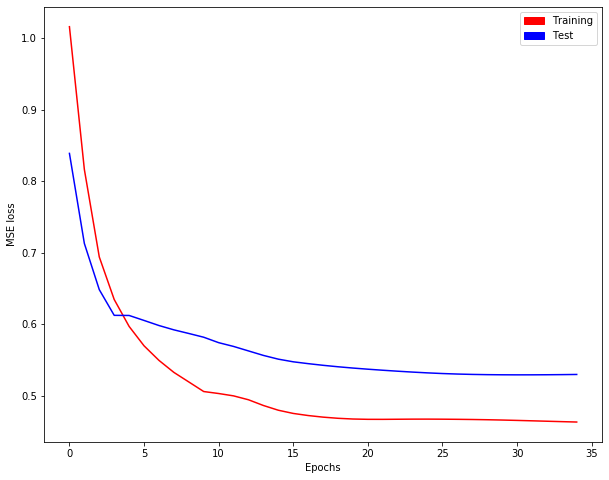

ValueError: x and y must have same first dimension, but have shapes (8760,) and (1, 29)

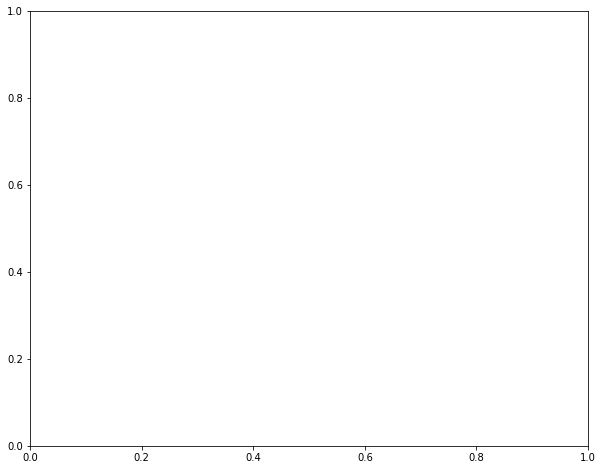

In [347]:
def plotting(history):
    plt.plot(history.history['loss'], color = "red")
    plt.plot(history.history['val_loss'], color = "blue")
    red_patch = mpatches.Patch(color='red', label='Training')
    blue_patch = mpatches.Patch(color='blue', label='Test')
    plt.legend(handles=[red_patch, blue_patch])
    plt.xlabel('Epochs')
    plt.ylabel('MSE loss')
    plt.show()

plt.figure(figsize=(10,8))
plotting(history) # Evolution of training/test loss

##
# Visual checking for a time series
##
## Mime model which is stateless but containing stateful weights
model_stateless = Sequential()
model_stateless.add(LSTM(input_shape=(None, dim_in),
               return_sequences=True, units=nb_units))
model_stateless.add(TimeDistributed(Dense(activation='linear', units=dim_out)))
model_stateless.compile(loss = 'mse', optimizer = 'rmsprop')
model_stateless.set_weights(model.get_weights())

## Prediction of a new set
i = 0 # time series selected (between 0 and N-1)
x = X_val
y = y_val
y_hat = model.predict(x)


for dim in range(1): # dim = 0 for y1 ; dim = 1 for y2 ; dim = 2 for y3.
    plt.figure(figsize=(10,8))
    plt.plot(range(T), y[:,dim])
    plt.plot(range(T), y_hat[:,dim])
    plt.show()
    
#     plt.figure(figsize=(10,8))
#     plt.plot(range(36), y[3600:3636,dim])
#     plt.plot(range(36), y_hat[3600:3636,dim])
#     plt.show()


In [355]:
y_hat.shape

(1, 8760, 29)

In [348]:
true_y_val = (y_val * np.array([building_energy_lstm_undo_zscore['sd_kwh']]) + np.array([building_energy_lstm_undo_zscore['mean_kwh']])).flatten()
true_y_predictions = (model.predict(X_val) * np.array([building_energy_lstm_undo_zscore['sd_kwh']]) + np.array([building_energy_lstm_undo_zscore['mean_kwh']])).flatten()
y_out = np.column_stack((true_y_predictions, true_y_val.astype(int)))
y_out = y_out[y_out[:, 1] != 0]

print("MAPE: " + str(100 * np.mean(np.abs(y_out[:, 0] / y_out[:, 1] - 1))))
print("CV(RMSE): " + str(100 * np.sqrt(np.mean(np.power(true_y_predictions - true_y_val, 2))) / np.mean(true_y_val)))
print("MBE: " + str(np.mean(true_y_predictions - true_y_val)))

MAPE: 42.95790160880418
CV(RMSE): 31.570273646753204
MBE: 4.135052142818206


In [226]:
building_energy_scaled_single = building_energy_scaled[building_energy_scaled['target_00600340190000'] == 1]

X = np.array(building_energy_scaled_single.drop(columns=['kwh_actual']))
y = np.array(building_energy_scaled_single.filter(items=['kwh_actual']))

X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X, y, test_size=0.3, shuffle = False)
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.5, shuffle = False)

train_undo_zscore = X_train[:, 4:6]
val_undo_zscore = X_val[:, 4:6]
test_undo_zscore = X_test[:, 4:6]

X_train = np.delete(X_train, [4, 5], 1)
X_val = np.delete(X_val, [4, 5], 1)
X_test = np.delete(X_test, [4, 5], 1)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(18412, 74) (3946, 74) (3946, 74) (18412, 1) (3946, 1) (3946, 1)


array([[ 0.47552631],
       [ 0.30141015],
       [ 0.38846823],
       ...,
       [-0.39505451],
       [-0.39505451],
       [-0.39505451]])

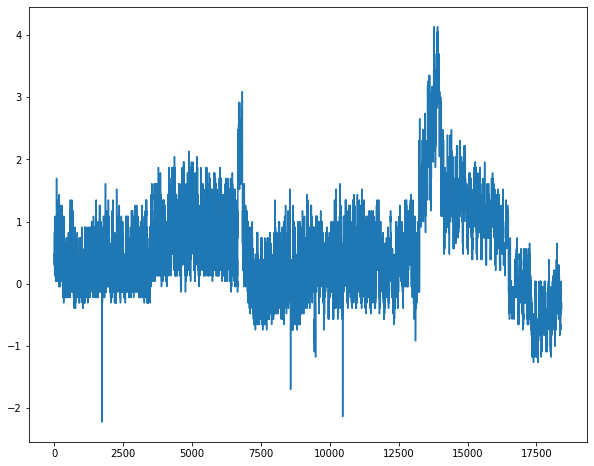

In [228]:
plt.figure(figsize=(10,8))
plt.plot(range(len(y_train)), y_train)
y_train

In [331]:
nn_model = Sequential()
nn_model.add(Dense(1, activation='relu', input_shape=[X_train.shape[1]]))
#nn_model.add(Dense(1))

nn_model.compile(optimizer=keras.optimizers.SGD(lr=0.01), loss='mean_squared_error')
early_stopping_monitor = EarlyStopping(patience=10)

nn_model.fit(X_train, y_train, validation_data=[X_val, y_val], epochs=1000, callbacks=[early_stopping_monitor])

Train on 18412 samples, validate on 3946 samples
Epoch 1/1000
18412/18412 [==============================] - 1s 29us/step - loss: 0.5056 - val_loss: 2.0856
Epoch 2/1000
18412/18412 [==============================] - 0s 26us/step - loss: 0.4299 - val_loss: 2.0983
Epoch 3/1000
18412/18412 [==============================] - 0s 26us/step - loss: 0.4266 - val_loss: 2.1473
Epoch 4/1000
18412/18412 [==============================] - 0s 26us/step - loss: 0.4243 - val_loss: 2.1250
Epoch 5/1000
18412/18412 [==============================] - 0s 26us/step - loss: 0.4236 - val_loss: 1.9775
Epoch 6/1000
18412/18412 [==============================] - 0s 26us/step - loss: 0.4231 - val_loss: 2.1561
Epoch 7/1000
18412/18412 [==============================] - 0s 26us/step - loss: 0.4243 - val_loss: 2.2770
Epoch 8/1000
18412/18412 [==============================] - 0s 26us/step - loss: 0.4228 - val_loss: 2.1526
Epoch 9/1000
18412/18412 [==============================] - 0s 26us/step - loss: 0.4236 - val_l

In [318]:
# Fully Connected Two-Layer NN Model
orig_nn_model = nn_model
y_predictions = orig_nn_model.predict(X_val)
true_y_predictions = np.multiply(y_predictions.ravel(), val_undo_zscore[:, 1]) + val_undo_zscore[:, 0]
true_y_val = np.multiply(y_val.ravel(), val_undo_zscore[:, 1]) + val_undo_zscore[:, 0]
y_out = np.column_stack((true_y_predictions, true_y_val.astype(int)))
y_out = y_out[y_out[:, 1] != 0]

print("MAPE: " + str(100 * np.mean(np.abs(y_out[:, 0] / y_out[:, 1] - 1))))
print("CV(RMSE): " + str(100 * np.sqrt(np.mean(np.power(true_y_predictions - true_y_val, 2))) / np.mean(true_y_val)))
print("MBE: " + str(np.mean(true_y_predictions - true_y_val)))

MAPE: 18.324742880553664
CV(RMSE): 19.16575578062846
MBE: 0.19793851101610174


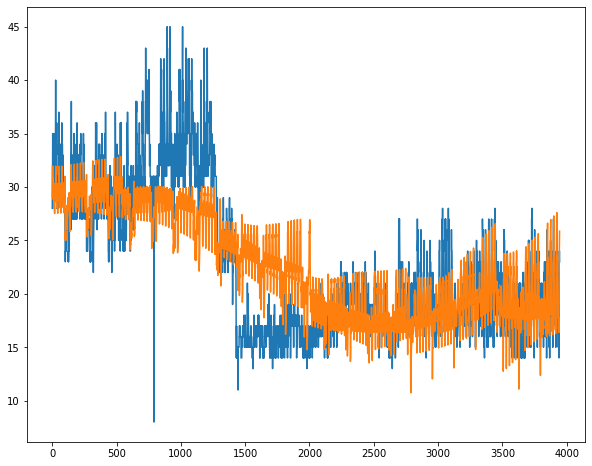

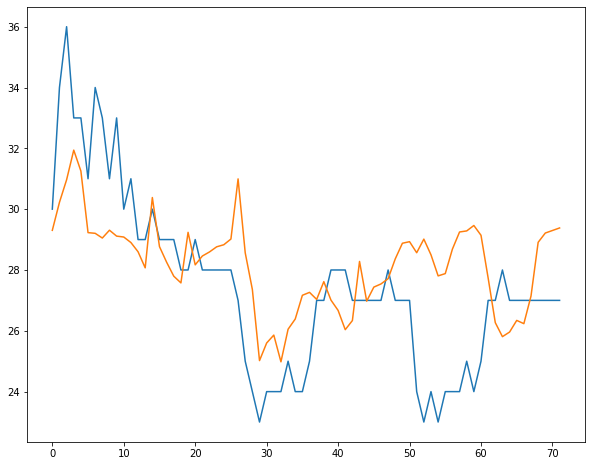

In [315]:
plt.figure(figsize=(10,8))
plt.plot(range(len(y_val)), true_y_val)
plt.plot(range(len(y_val)), true_y_predictions)

plt.figure(figsize=(10,8))
plt.plot(range(72), true_y_val[72:144])
plt.plot(range(72), true_y_predictions[72:144])

In [288]:
# LSTM Single Building Model
num_steps = 4

X_train_reshaped = np.reshape(X_train[:18352, :], newshape=(-1, num_steps, 74))
y_train_reshaped = np.reshape(y_train[:18352], newshape=(-1, num_steps, 1))
X_val_reshaped = np.reshape(X_val[:3848, :], newshape=(-1, num_steps, 74))
y_val_reshaped = np.reshape(y_val[:3848], newshape=(-1, num_steps, 1))

model = Sequential()
model.add(LSTM(20, activation='tanh', input_shape=(num_steps, 74), return_sequences=True))
model.add(Dense(units=20, activation='relu'))
model.add(Dense(units=1, activation='linear'))
adam = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=adam, loss='mse')

In [317]:
X_train.shape

(18412, 74)

In [291]:
model.fit(X_train_reshaped, y_train_reshaped, epochs=10)
val_predict = model.predict(X_val_reshaped)

Epoch 1/10
4588/4588 [==============================] - 0s 77us/step - loss: 0.3037
Epoch 2/10
4588/4588 [==============================] - 0s 76us/step - loss: 0.2974
Epoch 3/10
4588/4588 [==============================] - 0s 76us/step - loss: 0.2929
Epoch 4/10
4588/4588 [==============================] - 0s 75us/step - loss: 0.2889
Epoch 5/10
4588/4588 [==============================] - 0s 76us/step - loss: 0.2810
Epoch 6/10
4588/4588 [==============================] - 0s 76us/step - loss: 0.2766
Epoch 7/10
4588/4588 [==============================] - 0s 76us/step - loss: 0.2729
Epoch 8/10
4588/4588 [==============================] - 0s 76us/step - loss: 0.2710
Epoch 9/10
4588/4588 [==============================] - 0s 75us/step - loss: 0.2636
Epoch 10/10
4588/4588 [==============================] - 0s 76us/step - loss: 0.2630


In [309]:
true_y_predictions = np.multiply(val_predict.ravel(), val_undo_zscore_revised[:, 1]) + val_undo_zscore_revised[:, 0]
true_y_val = np.multiply(y_val_reshaped.ravel(), val_undo_zscore_revised[:, 1]) + val_undo_zscore_revised[:, 0]
y_out = np.column_stack((true_y_predictions, true_y_val.astype(int)))
y_out = y_out[y_out[:, 1] != 0]

print("MAPE: " + str(100 * np.mean(np.abs(y_out[:, 0] / y_out[:, 1] - 1))))
print("CV(RMSE): " + str(100 * np.sqrt(np.mean(np.power(true_y_predictions - true_y_val, 2))) / np.mean(true_y_val)))
print("MBE: " + str(np.mean(true_y_predictions - true_y_val)))

MAPE: 84.79775852313891
CV(RMSE): 74.65201981902307
MBE: 12.863675048522175


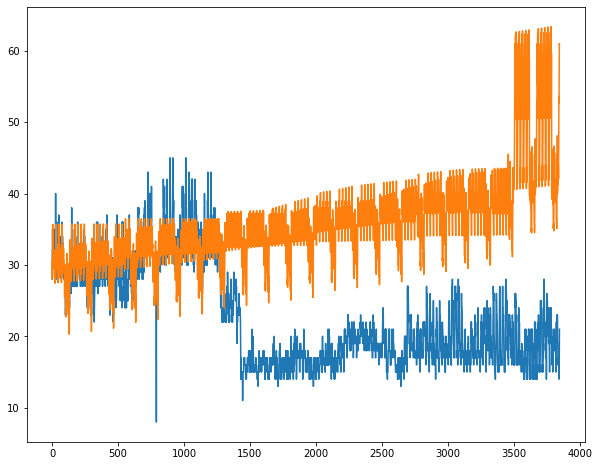

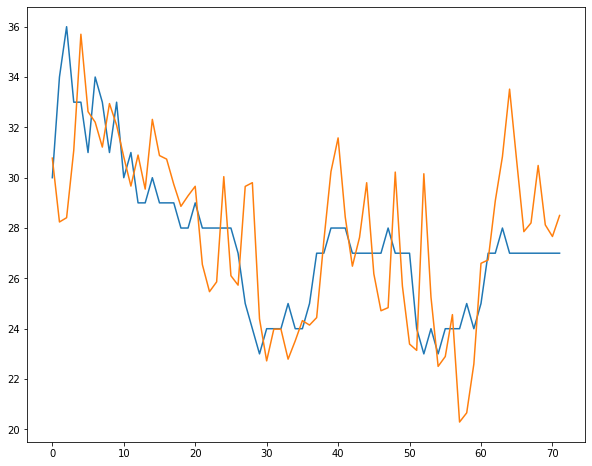

In [312]:
plt.figure(figsize=(10,8))
plt.plot(range(len(true_y_val)), true_y_val)
plt.plot(range(len(true_y_predictions)), true_y_predictions)

plt.figure(figsize=(10,8))
plt.plot(range(72), true_y_val[72:144])
plt.plot(range(72), true_y_predictions[72:144])